In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from iam import IAM, features_binary, alphabet, corpus

In [4]:
iam = IAM()

# Present the ambiguous input

We need to present features consistent with both 'WORK' and 'WORR'

Features that are both in K and R

In [5]:
rk_common_features = [min(K_f, K_r) for (K_f, K_r) in zip(features_binary['K'], features_binary['R'])]
rk_common_features

[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]

All features

In [6]:
ambiguous_input = np.array([
    features_binary['W'],
    features_binary['O'],
    features_binary['R'],
    rk_common_features
])
ambiguous_input

array([[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]])

In [7]:
def present_ambiguous_input():
    iam.feature_layer.activations = ambiguous_input.astype(float)

# Test

In [8]:
def get_letter_activation(position, letter):
    return iam.letter_layer.activations[position, alphabet.index(letter)]

In [9]:
def get_word_activation(word):
    word_index = corpus.word.tolist().index(word.lower())
    return iam.word_layer.activations[word_index]

In [10]:
def take_snapshot():
    for letter, activation_list in letter_activations_history.items():
        activation_list.append(get_letter_activation(position=3, letter=letter))
        
    for word, activation_list in word_activations_history.items():
        activation_list.append(get_word_activation(word))

In [11]:
letter_activations_history = dict(K=[], R = [], D = [])
word_activations_history = dict(WORK=[], WORD=[], WEAK=[], WEAR=[])

iam.reset_nodes()
present_ambiguous_input()

take_snapshot()
for _ in range(40):
    iam.run_cycle()
    take_snapshot()

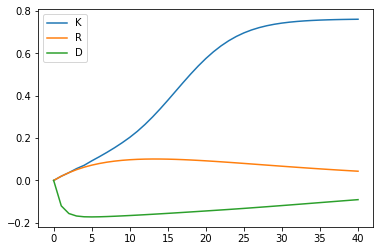

In [12]:
plt.plot(np.array(list(letter_activations_history.values())).T)
plt.legend(list(letter_activations_history.keys()))

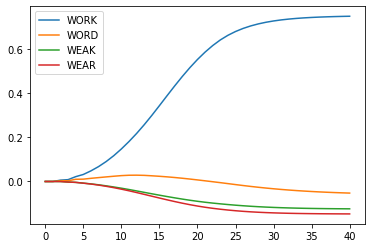

In [13]:
plt.plot(np.array(list(word_activations_history.values())).T)
plt.legend(list(word_activations_history.keys()))